# TRANSFORMER

In [1]:
import torch
import torch.nn as nn 
import math

## 0 Encoder Part of Transformer

### 0.1 InputEmbeddings

In [3]:
class InputEmbeddings(nn.Module):
    
    def __init__(self, d_model:int, vocab_size:int ) -> None:
        super().__init__()
        self.d_model = d_model   # d_model which represents the dimension of the model (i.e., the size of the word embeddings).
        self.vocab_size = vocab_size  # vocab_size which represents the size of the vocabulary. For instance, the GPT-3 model by OpenAI has a vocabulary size of approximately 14,735,746 words
        self.embedding = nn.Embedding(vocab_size, d_model)  # size of the word and vocab size, do the embedding 
        
        
    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model) # The embeddings are scaled by multiplying with the square root of d_model as recommended in the "Attention is All You Need" paper.
        

This piece of code defines a class named InputEmbeddings that inherits from nn.Module. nn.Module is the base class for all neural network modules in PyTorch, a popular deep learning library. This class, InputEmbeddings, represents an embedding layer in a neural network model.

Explanation of the Code

Let's break down the methods present in the class:

__init__(self, d_model:int, vocab_size:int ) -> None:

This is the constructor method for the class which initializes the instance. It takes three arguments:

self which represents the instance of the class.
d_model which represents the dimension of the model (i.e., the size of the word embeddings).
vocab_size which represents the size of the vocabulary.

In the body of the constructor, it calls the constructor of the parent class (nn.Module) with super().__init__(), stores the provided d_model and vocab_size into instance variables, and then initializes an embedding layer using PyTorch's nn.Embedding. nn.Embedding is a simple lookup table that stores embeddings of a fixed dictionary and size. The input to the module is a list of indices, and the output is the corresponding word embeddings.

forward(self, x):

This method defines the forward pass of the embedding layer. In other words, it describes how the module processes input data (x). It returns the input data passed through the embedding layer and scales the embedding according to the paper's recommendation by multiplying it by the square root of d_model. The scaling is a trick the authors of the "Attention is All You Need" paper use to get the model to learn better.

Key Points

InputEmbeddings is a class that defines an embedding layer in a neural network.
It inherits from the nn.Module class, the base class for all neural network modules in PyTorch.
The nn.Embedding layer is a simple lookup table that stores embeddings of a fixed dictionary and size.
The forward method defines how the module processes input data.
The embeddings are scaled by multiplying with the square root of d_model as recommended in the "Attention is All You Need" paper.

![Screenshot 2024-05-23 161712.png](<attachment:Screenshot 2024-05-23 161712.png>)
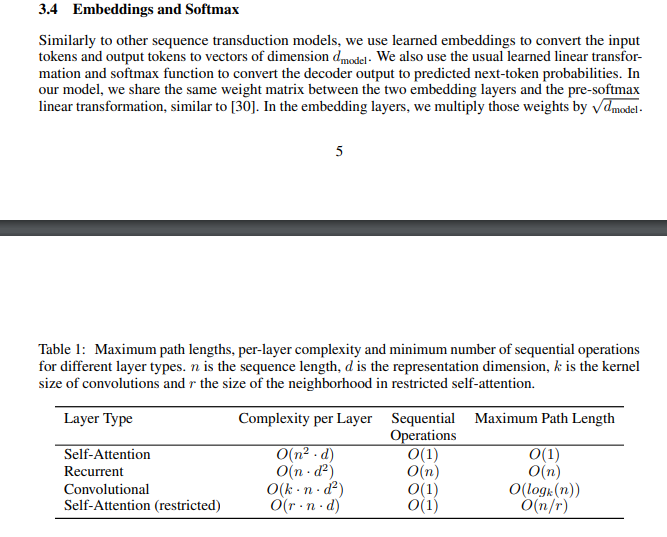

### 0.2 PositionalEncoding

In [5]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, 
                 d_model:int,  # this is the size of the vector that the positonal encoding should be 
                 seq_len:int,   # this is the maximum of the sentences because we need to create  one vector for each position
                 dropout:float  # dropout is to make the model less overfit
                 ) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len # seq_len(5) -> code will return the sequence 1, 2, 3, 4, 5. The seq_len function takes an integer argument n and generates a sequence of integers from 1 up to n. If n is less than or equal to 0, seq_len returns an empty integer vector.
        
        # The line `self.dropout = nn.Dropout(dropout)` in the provided code defines a dropout layer in the `PositionalEncoding` class. 
        # Dropout is a regularization technique commonly used in neural networks to prevent overfitting. It randomly sets a fraction of the input units to zero during training, which helps to prevent the co-adaptation of neurons and encourages the network to learn more robust and generalizable features.
        # In the code, `nn.Dropout(dropout)` creates a dropout layer with a specified dropout rate. The `dropout` argument is a float value between 0 and 1, representing the probability of setting an input unit to zero. For example, if `dropout` is set to 0.5, then during training, each input unit will be set to zero with a 50% probability.
        # By assigning the dropout layer to `self.dropout`, the `PositionalEncoding` class can apply dropout to the input tensor `x` in the `forward` method using `self.dropout(x)`.
        # In summary, the line `self.dropout = nn.Dropout(dropout)` creates a dropout layer with a specified dropout rate in the `PositionalEncoding` class, which helps to regularize the model and prevent overfitting.
        self.dropout = nn.Dropout(dropout) 
        
        # create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model) 
        
        # create a vector of shape (seq_len)
        # first we create a vector called the positon that will represent the positon of of the word inside the sentence 
        # and this vector can go from 0 to sequence length minus 1
        # .unsqueeze(1) ->  we are creating a tensor of shape sequence length one 
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        
        # create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        # Apply sine to even indices 
        # : -> every word position will have the sign 
        # 0 :: 2 -> but only the even dimension, starting from zero up to the end and going forward by two means from zero then the number two then the number four etc. 
        pe[:, 0::2] = torch.sin(position * div_term)
        
        # Apply cosine to odd indices 
        # 1::2 -> in this case start from one and go forward by two it means one three five etc.
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add to batch dimension to the positional encoding 
        # and then we need to add the batch dimension to this tensor so that we can apply it to the whole sentences so to all the batch  of the sentences because now the shape length of the d_model but we will have a batch of sentences   
        pe = pe.unsqueeze(0)
        
        # Register the positional encoding as a buffer 
        # finaly we will register the value of buffer of the module 
        # so basically when you have a tensor that you want to keep inside the module not as a parameter learned 
        # but you want it to be saved when you save the file of the model you should register it as a buffer this way the tensor will be saved in the file along with the state of the model 
        self.register_buffer('pe', pe)
        
        
    def forward(self, x):
        #(self.pe[:, :x.shape[1], :]),  pe -> positon encoding of this particular santence 
        # requires_grad_(False) -> and we also tell the model that we don't want to learn this positional encoding because 
        # they are fixed they will always be the same they are not learned along the training process 
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        
        # and then apply the dropout 
        return self.dropout(x)

![Screenshot 2024-05-24 141001.png](<attachment:Screenshot 2024-05-24 141001.png>)


        
![Screenshot 2024-05-24 141739.png](<attachment:Screenshot 2024-05-24 141739.png>)

        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)

        
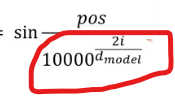

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        
        
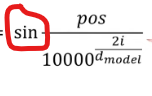

        pe[:, 0::2] = torch.sin(position * div_term)
        
![Screenshot 2024-05-24 142607.png](<attachment:Screenshot 2024-05-24 142607.png>)

        pe[:, 1::2] = torch.cos(position * div_term)





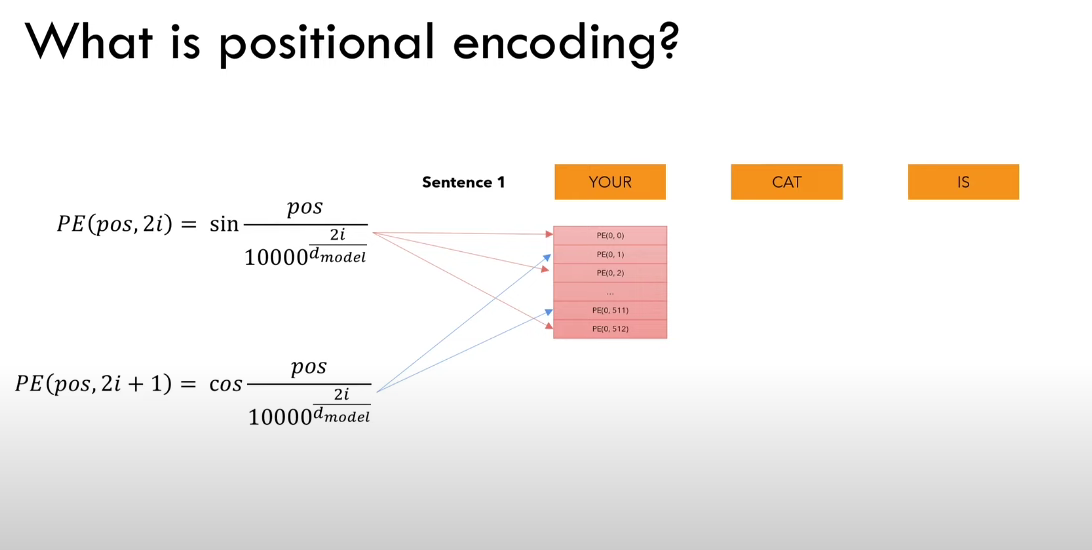
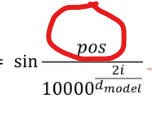
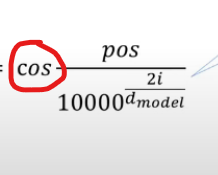

In [7]:
import torch 

seq_len = 5 
d_model = 10 

pe = torch.zeros(seq_len, d_model)
print(pe)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [14]:
seq_len = 5 

position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
print(position)

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.]])


In this example, seq_len is set to 5 and d_model is set to 10. The torch.zeros function creates a tensor with the specified shape (seq_len, d_model) and fills it with zeros. The resulting tensor pe is then printed to the console.

In summary, the example demonstrates how the code pe = torch.zeros(seq_len, d_model) can be used to create a tensor filled with zeros of a specified shape using the PyTorch library in Python.

The code `position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)` in Python using the PyTorch library creates a tensor `position` that represents the positions of elements in a sequence.

Here's a breakdown of the code:

- `torch.arange(0, seq_len, dtype=torch.float)`: This line generates a 1-dimensional tensor containing a sequence of numbers from 0 to `seq_len - 1`. The `torch.arange` function takes three arguments: the start value (0 in this case), the end value (`seq_len`), and the data type (`torch.float` in this case). It returns a tensor with the specified range of values.

- `.unsqueeze(1)`: This method call adds a new dimension of size 1 to the tensor. The `unsqueeze` function takes an argument `dim` that specifies the position where the new dimension should be inserted. In this case, `dim=1` indicates that the new dimension should be inserted as the second dimension of the tensor.

By combining these two operations, the code creates a tensor `position` that represents the positions of elements in a sequence. The tensor has a shape of `(seq_len, 1)`.

Here's an example of using the code:

```python
import torch

seq_len = 5

position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
print(position)
```

The output will be a tensor representing the positions of elements in a sequence:

```
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.]])
```

In this example, `seq_len` is set to 5. The code generates a tensor `position` with values ranging from 0 to 4, representing the positions of elements in a sequence. The resulting tensor is then printed to the console.

In summary, the code `position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)` creates a tensor that represents the positions of elements in a sequence. The tensor has a shape of `(seq_len, 1)`.

In [6]:
# div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

a = torch.arange(0, 10, 2).float() * (-math.log(10000.0) / 10)
print(a)


tensor([-0.0000, -1.8421, -3.6841, -5.5262, -7.3683])


Certainly! Let's break down the code snippet:

1. `torch.arange(0, d_model, 2)` creates a 1-D tensor with values starting from 0, incrementing by 2, and stopping before reaching `d_model`. The `torch.arange()` function generates a sequence of numbers, similar to the built-in `range()` function in Python. The resulting tensor contains values like `[0, 2, 4, 6, ...]`.

2. `(-math.log(10000.0) / d_model)` calculates the value of the exponential decay term. Here:
   - `math.log(10000.0)` computes the natural logarithm of 10000.
   - `d_model` represents a model dimension (usually associated with neural network architectures like Transformers).
   - The negative sign indicates that we're taking the reciprocal of the exponential term.

3. `torch.exp(...)` computes the element-wise exponential of the tensor obtained in step 2. This operation raises the base of the natural logarithm (e) to the power of each element in the tensor.

In summary, `div_term` is a tensor containing the exponential decay factors used in positional encodings for Transformer-based models. These factors help introduce positional information into the model's input embeddings, allowing it to handle sequences effectively. The specific use case depends on the context of your code. If you're working with Transformers or similar architectures, this term is crucial for positional encoding.



The `register_buffer` method in PyTorch is used to add a buffer to a neural network module. Buffers are typically used to store auxiliary information that should not be considered as model parameters. Here are the key points about `register_buffer`:

1. **Purpose**:
   - Buffers are part of the module's state but are not considered trainable parameters.
   - They are useful for storing non-learnable quantities, such as running statistics in Batch Normalization layers or other intermediate values.
   - Unlike parameters, buffers are not updated during training.

2. **Syntax**:
   ```python
   self.register_buffer(name, tensor, persistent=True)
   ```
   - `name`: A string representing the name of the buffer.
   - `tensor`: The tensor to be registered as a buffer.
   - `persistent`: A boolean indicating whether the buffer should be saved alongside the model when serialized (default is `True`).

3. **Example**:
   Suppose you have a custom module with a buffer named `'pe'`:
   ```python
   class MyModule(nn.Module):
       def __init__(self):
           super().__init__()
           # Create a buffer 'pe' (e.g., for positional encodings)
           self.register_buffer('pe', pe)

       def forward(self, x):
           # Use the buffer 'pe' in your forward pass
           # ...
           return output
   ```

4. **Use Cases**:
   - Common use cases include storing moving averages (e.g., in BatchNorm), precomputed embeddings, or other fixed values needed during inference.
   - Buffers are automatically moved to the same device as the module.

Remember that buffers are not optimized during training, but they are essential for maintaining state within the module. If you have quantities that should be part of the model's state but not updated by the optimizer, consider using `register_buffer`. ¹⁴



Certainly! Let's explore an example of auxiliary information in the context of **image recognition**.

Suppose we have a deep learning model that identifies different types of fruits in images. The primary information for the model is the raw pixel data of the image itself. However, auxiliary information can significantly improve the accuracy of the fruit recognition task:

1. **Auxiliary Information**:
   - **Color Histograms**: We can compute histograms of color distribution (e.g., RGB values) within the image. These histograms provide additional context about the dominant colors present in the fruit.
   - **Texture Features**: Extracting texture features (such as Haralick features or Gabor filters) from the image can help distinguish between smooth-skinned fruits (like apples) and textured fruits (like pineapples).
   - **Shape Descriptors**: Auxiliary shape descriptors (e.g., circularity, elongation) can help differentiate round fruits (like oranges) from elongated ones (like bananas).
   - **Metadata**: If available, metadata about the image (e.g., location, lighting conditions, camera type) can provide context that aids in recognition.

2. **How It Works**:
   - During training, the model learns to combine both the raw pixel data and the auxiliary features to make accurate predictions.
   - For example, if the model encounters an image of a yellow, round fruit with a smooth texture, it can use the color histogram, shape descriptors, and texture features to narrow down the possibilities (e.g., it's likely an orange).

3. **Benefits**:
   - Improved Robustness: Auxiliary information makes the model more robust to variations in lighting, background, and image quality.
   - Generalization: By incorporating shape and texture features, the model can generalize better to unseen fruits.

Remember that auxiliary information varies depending on the specific task and domain. In this example, we focused on image recognition, but similar principles apply to other fields as well. If you'd like more examples or have any other questions, feel free to ask! 😊

![Screenshot 2024-05-24 133038.png](<attachment:Screenshot 2024-05-24 133038.png>)
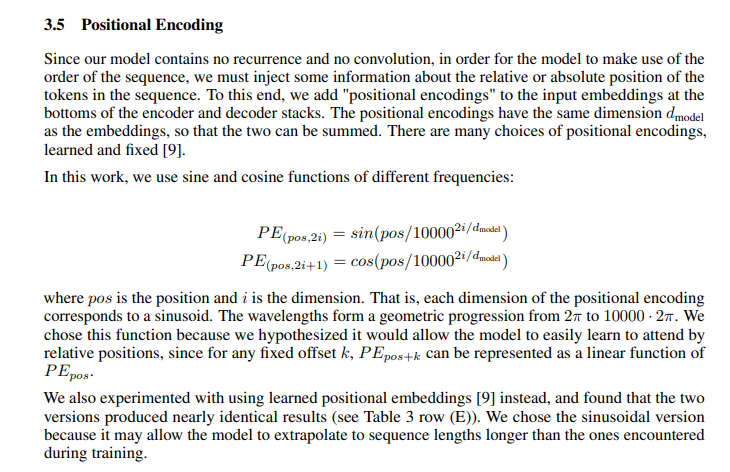

### 0.3 Normalization